In [97]:
using DataFrames, Gadfly

In [98]:
function proportionality_correlation(xs, ys, cx, cy)
    xs += cx
    ys += cy
    lx = log(xs)
    ly = log(ys)
    return 2*cov(lx, ly) / (var(lx) + var(ly))
end

proportionality_correlation (generic function with 1 method)

In [125]:
function mrd(xs, ys, cx, cy)
    xs += cx
    ys += cy

#     xs_q3 = quantile(xs, 0.75)
#     ys_q3 = quantile(ys, 0.75)
#     shift = xs_q3 / ys_q3
#     xs /= shift
    
    err = abs((xs .- ys) ./ (xs .+ ys));
    for (i, x) in enumerate(err)
        if !isfinite(err[i])
            err[i] = 0.0
        end
    end
    return mean(err)
end

mrd (generic function with 1 method)

In [99]:
    long_labels  = Dict(
        "isolator"           => "Isolator",
        "rsem-ml"            => "RSEM/ML",
        "rsem-pm"            => "RSEM/PM",
        "bitseq"             => "BitSeq",
        "cufflinks"          => "Cufflinks",
        "express"            => "eXpress",
        "sailfish"           => "Sailfish",
        "salmon"             => "Salmon",
        "kallisto"           => "Kallisto")

ord = ["Isolator",
    "RSEM/ML",
    "RSEM/PM",
    "BitSeq",
    "Cufflinks",
    "eXpress",
    "Sailfish",
    "Salmon",
    "Kallisto"]


9-element Array{ASCIIString,1}:
 "Isolator" 
 "RSEM/ML"  
 "RSEM/PM"  
 "BitSeq"   
 "Cufflinks"
 "eXpress"  
 "Sailfish" 
 "Salmon"   
 "Kallisto" 

In [100]:
cons = readtable("analysis/seqc/transcript-expression-consistency.tsv", header=true);
head(cons)

,transcript_id,method,sample,value,expected
1,ENST00000000233,isolator,C,110.15528016740764,109.37745096692578
2,ENST00000000412,isolator,C,48.5443473363042,39.01955432343176
3,ENST00000000442,isolator,C,29.768078574484885,27.97051228408131
4,ENST00000001008,isolator,C,148.341691851087,143.29652455945873
5,ENST00000001146,isolator,C,2.6123229968412236,3.0999609827016266
6,ENST00000002125,isolator,C,12.105008252540571,10.771911492218036


In [101]:
cons_a = cons[cons[:sample] .== "C",:]
head(cons_a)

,transcript_id,method,sample,value,expected
1,ENST00000000233,isolator,C,110.15528016740764,109.37745096692578
2,ENST00000000412,isolator,C,48.5443473363042,39.01955432343176
3,ENST00000000442,isolator,C,29.768078574484885,27.97051228408131
4,ENST00000001008,isolator,C,148.341691851087,143.29652455945873
5,ENST00000001146,isolator,C,2.6123229968412236,3.0999609827016266
6,ENST00000002125,isolator,C,12.105008252540571,10.771911492218036


In [126]:
result = DataFrame()
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    result_c = by(cons_a, [:method], df -> proportionality_correlation(df[:value], df[:expected], c, c))
    result_c[:c] = c
    result = vcat(result, result_c)
end

In [127]:
names!(result, [:method, :cor, :c]);

In [128]:
result[:method] = [string(method) for method in result[:method]]
result[:method] = [get(long_labels, method, method) for method in result[:method]];

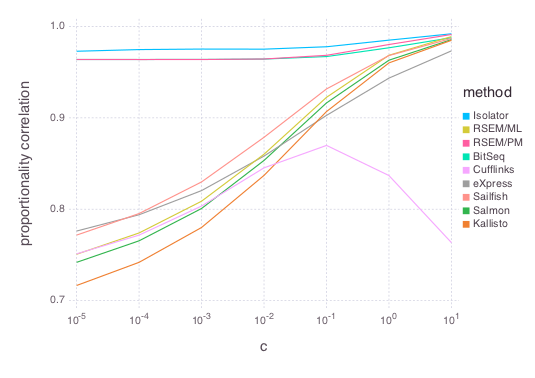

In [129]:
pl = plot(result, x=:c, y=:cor, color=:method, Scale.x_log10, Geom.line,
    Guide.ylabel("proportionality correlation"),
      Scale.color_discrete(levels=ord))

In [106]:
draw(SVG("pc-constant-seqc-transcript-expression-consistency.svg", 5inch, 3inch), pl)
draw(PDF("pc-constant-seqc-transcript-expression-consistency.pdf", 5inch, 3inch), pl)

In [130]:
result = DataFrame()
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    result_c = by(cons_a, [:method], df -> mrd(df[:value], df[:expected], c, c))
    result_c[:c] = c
    result = vcat(result, result_c)
end

names!(result, [:method, :cor, :c]);
result[:method] = [string(method) for method in result[:method]]
result[:method] = [get(long_labels, method, method) for method in result[:method]];

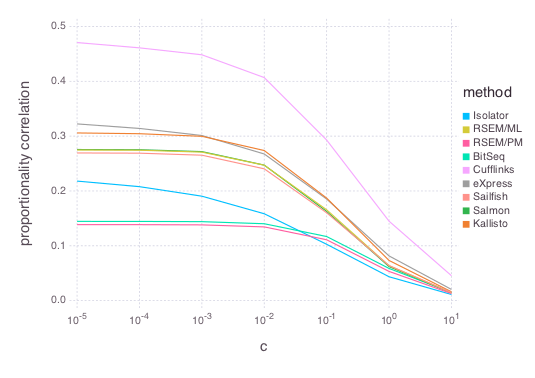

In [131]:
pl = plot(result, x=:c, y=:cor, color=:method, Scale.x_log10, Geom.line,
    Guide.ylabel("proportionality correlation"),
      Scale.color_discrete(levels=ord))

# PrimePCR

In [81]:
function approximate_tpm(control, tpms)
    #scale = median([median(tpm) for tpm in tpms]) / median(control)
    scale = median([quantile(tpm, 0.75) for tpm in tpms]) / quantile(control, 0.75)
    return scale * control
end

approximate_tpm (generic function with 1 method)

In [82]:
primepcr = readtable("analysis/seqc/qpcr-primepcr-A-comparison.tsv", header=true);

In [83]:
methods = ["isolator", "cufflinks", "express", "kallisto", "rsem_ml",
           "rsem_pm", "bitseq", "sailfish", "salmon"]
primepcr[:qpcr] = approximate_tpm(primepcr[:qpcr],
                    [primepcr[symbol(method)] for method in methods]);



In [84]:
primepcr = melt(primepcr, [:gene_id, :qpcr])
names!(primepcr, [:method, :value, :gene_id, :qpcr])
head(primepcr)

,method,value,gene_id,qpcr
1,isolator,42.58722033827255,ENSG00000000003,26.34505787729733
2,isolator,1.009094008015287,ENSG00000000005,1.132460275360449
3,isolator,79.90740063470872,ENSG00000000419,159.72656268117944
4,isolator,5.896405046835458,ENSG00000000457,6.274325798645061
5,isolator,22.789210181015903,ENSG00000000460,47.81728934317327
6,isolator,0.0013332310105899246,ENSG00000000938,0.052536374111676575


In [85]:
result = DataFrame()
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    result_c = by(primepcr, [:method], df -> proportionality_correlation(df[:value], df[:qpcr], c, c))
    result_c[:c] = c
    result = vcat(result, result_c)
end
names!(result, [:method, :cor, :c])
head(result)

,method,cor,c
1,bitseq,0.6749529214977557,1.0e-5
2,cufflinks,0.7629493160594667,1.0e-5
3,express,0.7626368673165719,1.0e-5
4,isolator,0.792690274253772,1.0e-5
5,kallisto,0.7528654499889713,1.0e-5
6,rsem_ml,0.7583393475036254,1.0e-5


In [86]:
    long_labels  = Dict(
        "isolator"           => "Isolator",
        "rsem_ml"            => "RSEM/ML",
        "rsem_pm"            => "RSEM/PM",
        "bitseq"             => "BitSeq",
        "cufflinks"          => "Cufflinks",
        "express"            => "eXpress",
        "sailfish"           => "Sailfish",
        "salmon"             => "Salmon",
        "kallisto"           => "Kallisto")

result[:method] = [string(method) for method in result[:method]]
result[:method] = [get(long_labels, method, method) for method in result[:method]];


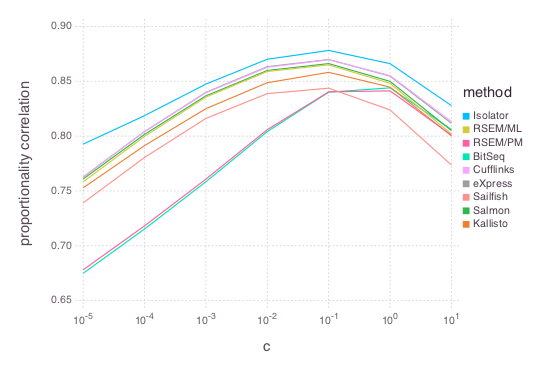

In [87]:
pl = plot(result, x=:c, y=:cor, color=:method, Scale.x_log10, Geom.line,
          Guide.ylabel("proportionality correlation"),
          Scale.color_discrete(levels=ord))

In [89]:
draw(SVG("pc-constant-seqc-primepcr.svg", 5inch, 3inch), pl)
draw(PDF("pc-constant-seqc-primepcr.pdf", 5inch, 3inch), pl)

In [164]:
function threshold(xs, c)
    return Float64[x <= c ? 0.0 : x for x in xs]
end

threshold (generic function with 1 method)

In [165]:
result = DataFrame()
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    result_c = by(primepcr, [:method], df ->
        proportionality_correlation(
            threshold(df[:value], c),
            threshold(df[:qpcr], c), 0.0, 0.0))
    result_c[:c] = c
    result = vcat(result, result_c)
end
names!(result, [:method, :cor, :c])
head(result)

,method,cor,c
1,bitseq,NaN,1.0e-5
2,cufflinks,NaN,1.0e-5
3,express,NaN,1.0e-5
4,isolator,NaN,1.0e-5
5,kallisto,NaN,1.0e-5
6,rsem_ml,NaN,1.0e-5


In [132]:
result = DataFrame()
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    result_c = by(primepcr, [:method], df -> mrd(df[:value], df[:qpcr], c, c))
    result_c[:c] = c
    result = vcat(result, result_c)
end
names!(result, [:method, :cor, :c])

long_labels  = Dict(
        "isolator"           => "Isolator",
        "rsem_ml"            => "RSEM/ML",
        "rsem_pm"            => "RSEM/PM",
        "bitseq"             => "BitSeq",
        "cufflinks"          => "Cufflinks",
        "express"            => "eXpress",
        "sailfish"           => "Sailfish",
        "salmon"             => "Salmon",
        "kallisto"           => "Kallisto")

result[:method] = [string(method) for method in result[:method]]
result[:method] = [get(long_labels, method, method) for method in result[:method]];

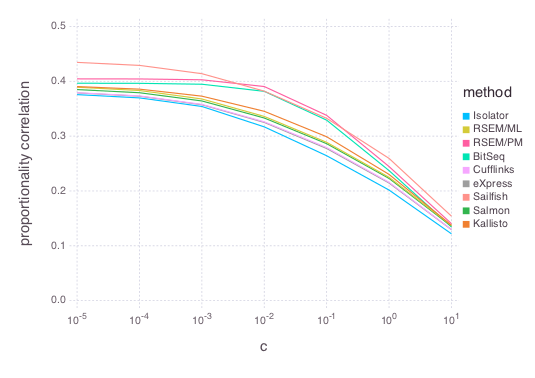

In [133]:
pl = plot(result, x=:c, y=:cor, color=:method, Scale.x_log10, Geom.line,
          Guide.ylabel("proportionality correlation"),
          Scale.color_discrete(levels=ord))

# MRD

In [119]:

function mrd(xs, ys, cx, cy)
    xs += cx
    ys += cy

    xs_q3 = quantile(xs, 0.75)
    ys_q3 = quantile(ys, 0.75)
    shift = xs_q3 / ys_q3
    xs /= shift
    
    err = abs((xs .- ys) ./ (xs .+ ys));
    for (i, x) in enumerate(err)
        if !isfinite(err[i])
            err[i] = 0.0
        end
    end
    return mean(err)
end

mrd (generic function with 1 method)

In [120]:
result = DataFrame()
for c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    result_c = by(cons_a, [:method], df -> mrd(df[:value], df[:expected], c, c))
    result_c[:c] = c
    result = vcat(result, result_c)
end

In [121]:
names!(result, [:method, :cor, :c]);

In [122]:
result[:method] = [string(method) for method in result[:method]]
result[:method] = [get(long_labels, method, method) for method in result[:method]];

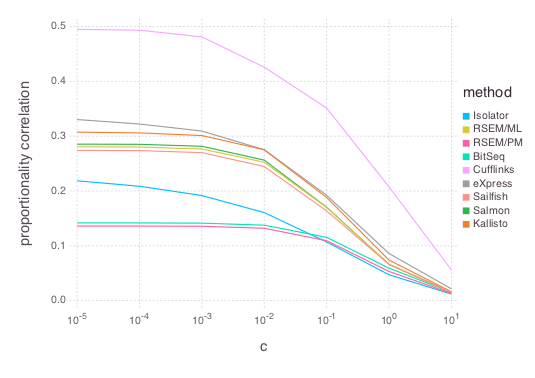

In [123]:
pl = plot(result, x=:c, y=:cor, color=:method, Scale.x_log10, Geom.line,
    Guide.ylabel("proportionality correlation"),
      Scale.color_discrete(levels=ord))